In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from collections import defaultdict

In [ ]:
train_id = '1-E-EfSZcREnhyMe23tluDmzNnS2pWSE_'
train_file = drive.CreateFile({'id':train_id}) 
train_file.GetContentFile('train.csv')  
train_df = pd.read_csv('train.csv')

test_id = '1-498FRSmoGj1AqpuPIHU5P8tIwuHEzN1'
test_file = drive.CreateFile({'id':test_id})
test_file.GetContentFile('test.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,7411,7.0,2013-03-20,Germany Republi,1203,CES,37.228664,-3.256505,Kwa Abdalla,0,Pangani,Mafurini,Kilimanjaro,3,5,Hai,Machame Kaskazini,90,True,GeoData Consultants Ltd,Water Board,Machame water supply,True,2008,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,18014,0.0,2011-02-21,Cdtf,1409,CDTF,34.615481,-9.972601,none,0,Lake Nyasa,Ituni,Iringa,11,5,Ludewa,Luana,70,False,GeoData Consultants Ltd,Private operator,Mgowel,False,1984,gravity,gravity,gravity,private operator,commercial,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2,26103,0.0,2013-01-04,Government Of Tanzania,1572,DWE,36.658778,-3.321529,Kwa Loishiye,0,Pangani,Melebuki,Arusha,2,2,Arusha Rural,Kimnyaki,150,True,GeoData Consultants Ltd,VWC,Saitero olosaita pipe line,True,2002,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
3,31140,0.0,2011-04-03,District Council,0,District Council,33.628025,-8.860795,Mwanzechele,0,Rufiji,Darajani,Mbeya,12,2,Mbeya Rural,Inyala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,wug,user-group,pay annually,annually,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,functional
4,12286,300.0,2013-03-08,District Council,1283,District Council,37.655509,-3.669777,Kwa Kidaya,0,Pangani,Mwira A,Kilimanjaro,3,2,Mwanga,Shinghatini,34,True,GeoData Consultants Ltd,VWC,Churu water supply,False,2007,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional



*   The dataset is a rich combination of both numeric and categorical data. A few columns like 'region' and 'region_code' give repeated information and can be intuitively dropped while preprocessing.
*   The target variable is named as 'status_group'.

In [ ]:
train_df.shape

(44550, 41)

The whole dataset contains 41 columns in total; 40 feature columns and 1 target variable column. A total of 44550 records (datapoints) are available.

In [ ]:
set(train_df['status_group'])

{'functional', 'functional needs repair', 'non functional'}

From the above, it can be seen that the target variable has three categories namely, 'functional', 'functional needs repair' and 'non functional'.

In [ ]:
for col in train_df.columns.values:
  un = set(train_df[col])
  null = sum(pd.isna(train_df[col]))
  print(col + ' : datatype is ' + str(train_df[col].dtypes) + ' and has: ')
  print(str(len(un)) + ' unique values and ' + str(null) + ' null values.')
  print(end='\n')

cat_data = [col for col in train_df.columns.values if train_df[col].dtypes=='object']
print('Total number of columns with object data: ', len(cat_data))

id : datatype is int64 and has: 
44550 unique values and 0 null values.

amount_tsh : datatype is float64 and has: 
85 unique values and 0 null values.

date_recorded : datatype is object and has: 
346 unique values and 0 null values.

funder : datatype is object and has: 
1652 unique values and 2793 null values.

gps_height : datatype is int64 and has: 
2396 unique values and 0 null values.

installer : datatype is object and has: 
1855 unique values and 2807 null values.

longitude : datatype is float64 and has: 
43155 unique values and 0 null values.

latitude : datatype is float64 and has: 
43155 unique values and 0 null values.

wpt_name : datatype is object and has: 
28991 unique values and 0 null values.

num_private : datatype is int64 and has: 
59 unique values and 0 null values.

basin : datatype is object and has: 
9 unique values and 0 null values.

subvillage : datatype is object and has: 
16618 unique values and 287 null values.

region : datatype is object and has: 
21 u

From the above output, the major insights found are:


*   There are 31 columns with object/categorical data type.
*   'scheme_name' has a lot of null values, a total of 21110.
*   



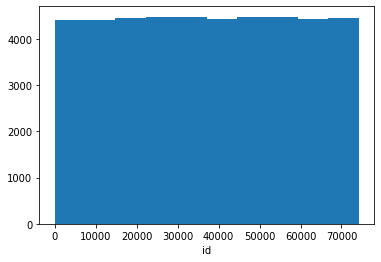

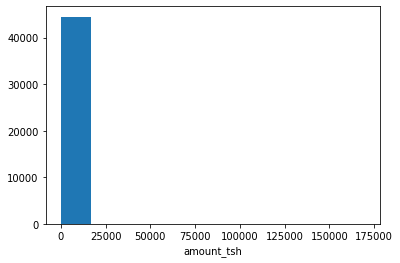

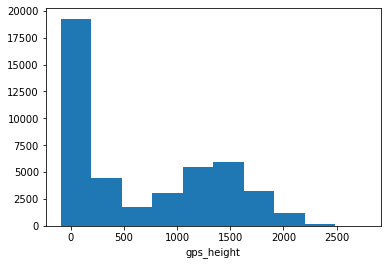

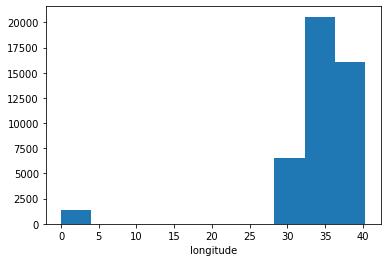

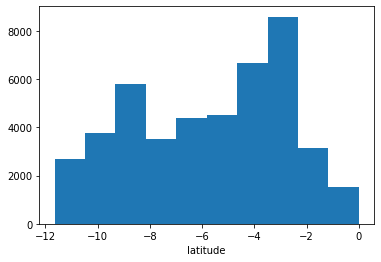

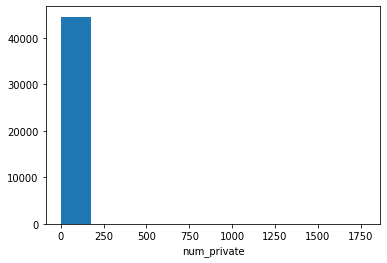

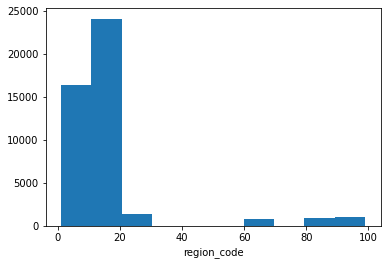

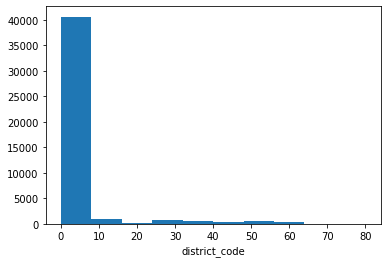

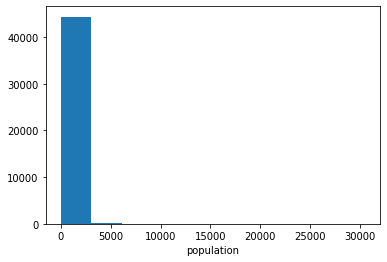

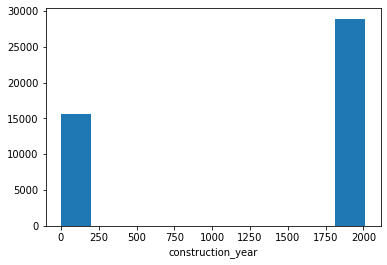

In [ ]:
## plotting all the histograms
for col in train_df.columns.values:
  if train_df[col].dtypes != 'object':
    plt.hist(train_df[col])
    plt.xlabel(col)
    plt.show()

1. There are around 15000 entries with construction year as 0 which implies that the construction year is not known. 

In [ ]:
# Replacing the unknown values in 'construction_year' with the median value of the column
med = train_df['construction_year'].median()

for i in range(train_df.shape[0]):
  if train_df['construction_year'][i] == 0:   
    train_df['construction_year'][i] = med

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Correlation Tests!

In [ ]:
! pip install dython
from dython.nominal import theils_u

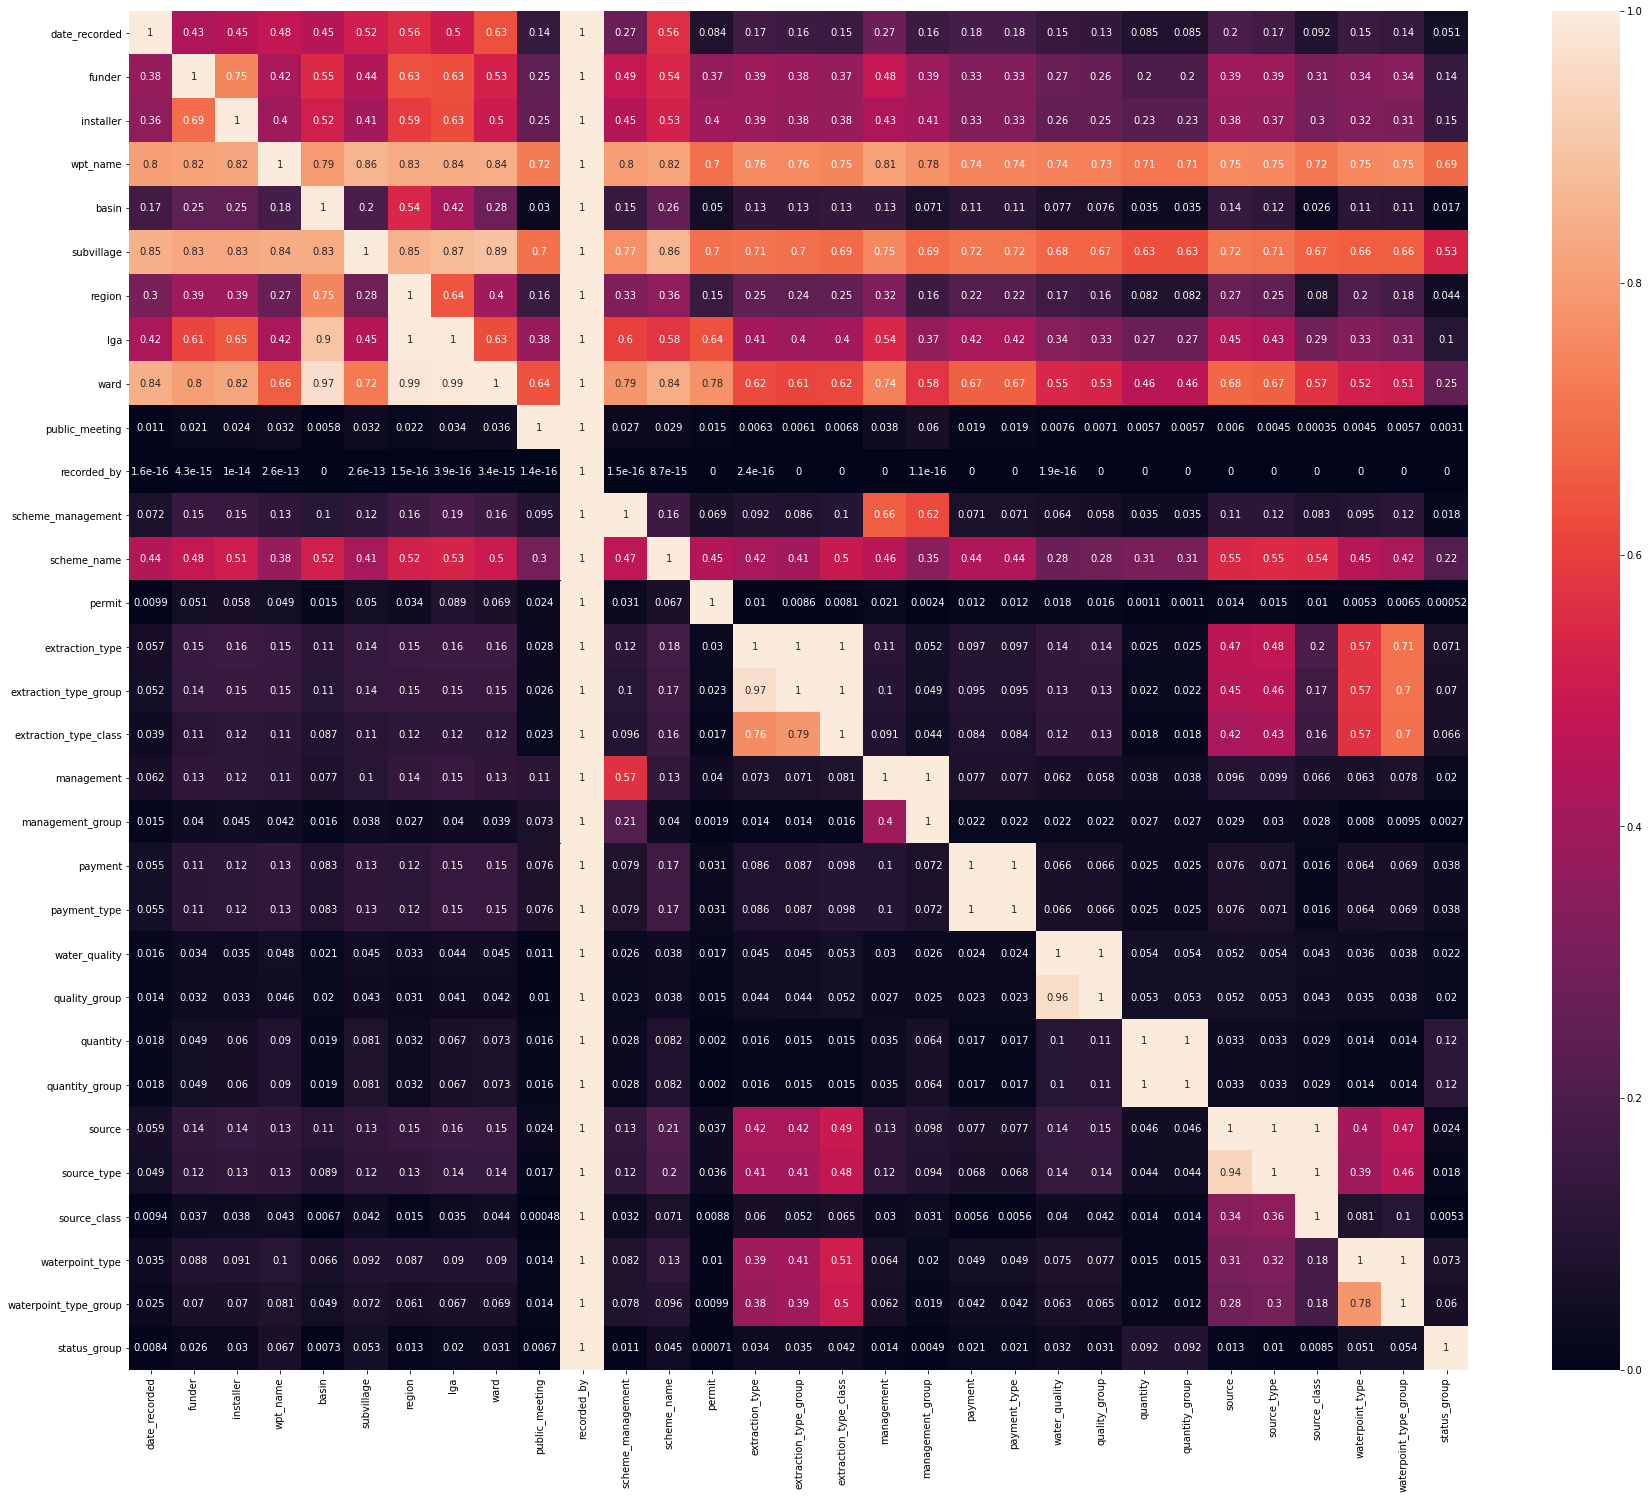

In [ ]:
#1. Correlation between categorical variables (Metric used is Theils U as Pearson's Chi-Square Test didn't consider the symmetry aspect)
## Reference used: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

cat_corr = pd.DataFrame(np.zeros([31,31]), index=cat_data, columns=cat_data)
for col1 in cat_data:
  for col2 in cat_data:
    cat_corr[col1][col2]=theils_u(train_df[col1], train_df[col2])

fig, ax = plt.subplots(figsize=(30,25))
sns.heatmap(abs(cat_corr), annot=True)
plt.show() 



1.   Most of the initial columns contain information about the location of the pump and so are highly correlated with many of these have high correlation with the other variables. For ex, ward, subvillage, wpt_name etc.
2.   A few more columns have redundant information with just another way of expression. For example, source and source type have a correlation of 0.94 and 1 with each other (conditional probabilities, takes into consideration the symmetry factor)
3.   No variable shows a high direct correlation with the target variable.

It can be seen that knowing source_type gives us a 94% chance that we know the source however, knowing the source gives us a 100% chance that we know the source_type. So, 'source_type' can be deleted.



In [ ]:
train_df = train_df.drop('recorded_by', axis=1) ## removing 'recorded_by' column as it has only 1 unique value for all records (both train and test) and hence, has no effect on the target variable.

In [ ]:
#2. Correlation between Numerical Data Columns (using Pearson's and Spearman's correlation)

num_data = [col for col in train_df.columns.values if train_df[col].dtypes != 'object']
num_df = train_df[num_data]

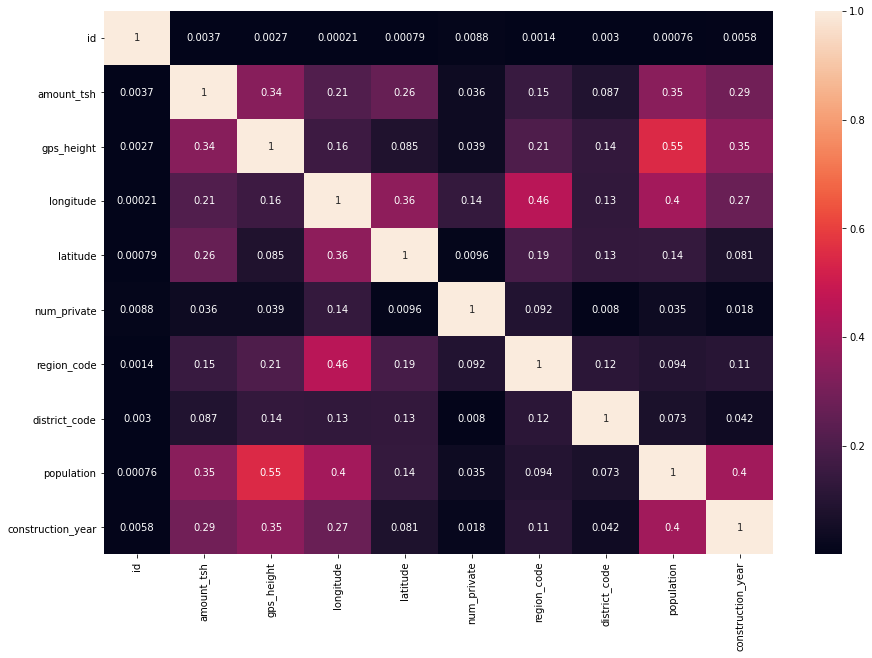

In [ ]:
## Spearman's Correlation

corrMatrix_s = num_df.corr(method='spearman')
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(abs(corrMatrix_s), annot=True)
plt.show() 

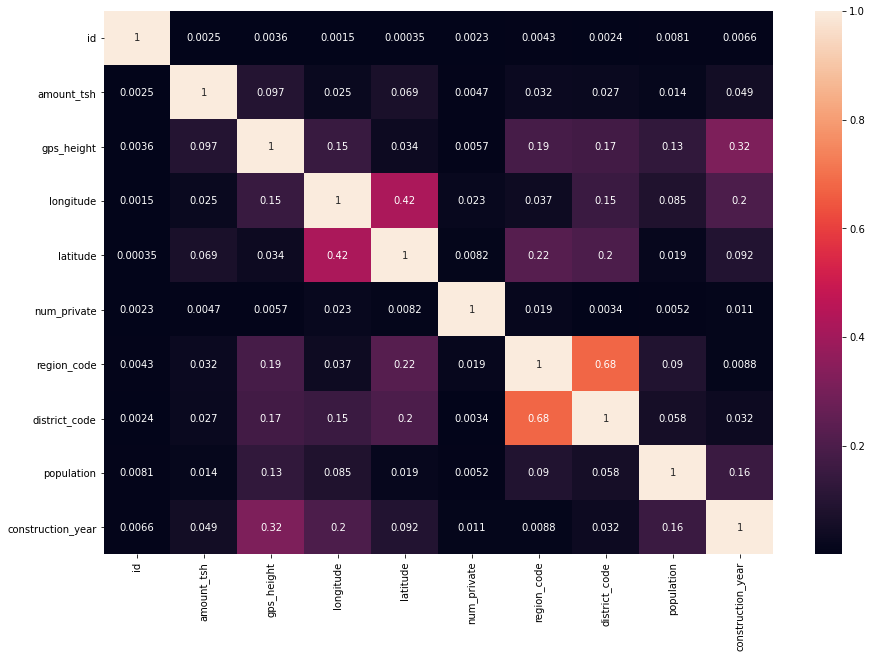

In [ ]:
## Pearson's Correlation

corrMatrix_p = num_df.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(abs(corrMatrix_p), annot=True)
plt.show() 

None of the numerical features have a good correlation with each other and so feature elimination is not a good idea on this basis.

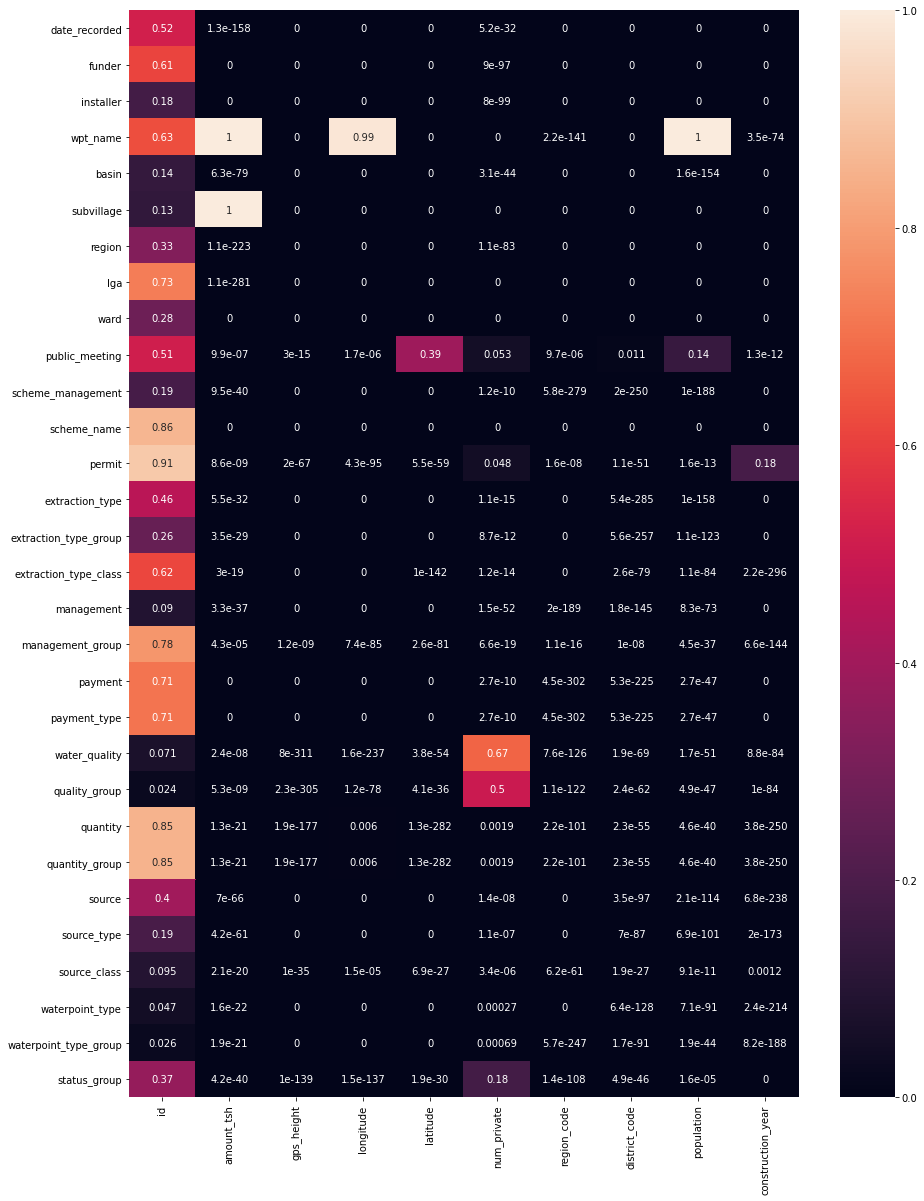

In [ ]:
#3. Correlation between Categorical and Numerical Data Columns
## reference used: https://thinkingneuron.com/how-to-measure-the-correlation-between-a-numeric-and-a-categorical-variable-in-python/

from scipy.stats import f_oneway
 
# Running the one-way anova test between cat_data and num_data
# Assumption(H0) is that they are NOT correlated

cat_data = [col for col in train_df.columns.values if train_df[col].dtypes=='object']
cat_num_corr = pd.DataFrame(np.zeros([30,10]), index=cat_data, columns=num_data)

for col1 in cat_data:
  for col2 in num_data:
    # Finds out the col2 (num_data) for each col1 (cat_data) as a list
    CategoryGroupLists=train_df.groupby(col1)[col2].apply(list)
 
    # Performing the ANOVA test
    # We accept the Assumption(H0) only when P-Value > 0.05
    AnovaResults = f_oneway(*CategoryGroupLists)

    cat_num_corr[col2][col1] = AnovaResults[1]

fig, ax = plt.subplots(figsize=(15,20))
sns.heatmap(abs(cat_num_corr), annot=True)
plt.show() 

We know that a p value of exact 0 means that the null hypothesis is rejected and our test is statistically significant which implies that the differences between our groups are significant.

Insights from above heatmap:


*   From the above, it can be seen that many columns show a good correlation (a p-value > 0.05).
*   However, for the same columns, the p-value is 0 while considering its correlation with other variables. This means that they don't have any overlapping correlation and so both are independently significant.




# Feature Elimination based on above analysis!

It can be assumed intuitively that amount_tsh,	gps_height,	basin,	installer, population,	scheme_management,	construction	year,	 extraction_type,	management_group,	water_quality, payment	type,	source,	and	 waterpoint_type can be very important variables in predicting pump quality.

From above analysis, gps_height, 

There are many groups of features:

(quantity, quantity_group), (extraction_type,	extraction_type_group,	extraction_type_class),	(payment,	payment_type),	(water_quality,	quality_group),	(source,	source_type, source_class),	(subvillage,	region,	region_code,	district_code,	lga,	ward),	and	(waterpoint_type,	waterpoint_type_group)	

All of these represent similar data but in different forms. From the correlation analysis, we can remove a few of them to avoid redundant features and overfitting.

Removing quantity_group, extraction_type, extraction_type_group, payment_type, water_quality, source_type, source_class, waterpoint_type_group, region, lga, ward.

In [ ]:
train_df_final = train_df.drop(['id','date_recorded','scheme_name', 'region', 'quantity_group', 'extraction_type', 'extraction_type_group', 'payment_type', 'water_quality', 'source_type', 'source_class', 'waterpoint_type_group', 'lga', 'ward'], axis=1)

In [ ]:
train_df_final.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,quality_group,quantity,source,waterpoint_type,status_group
0,7.0,Germany Republi,1203,CES,37.228664,-3.256505,Kwa Abdalla,0,Pangani,Mafurini,3,5,90,True,Water Board,True,2008,gravity,water board,user-group,pay per bucket,good,enough,spring,communal standpipe,functional
1,0.0,Cdtf,1409,CDTF,34.615481,-9.972601,none,0,Lake Nyasa,Ituni,11,5,70,False,Private operator,False,1984,gravity,private operator,commercial,never pay,good,enough,spring,communal standpipe,functional
2,0.0,Government Of Tanzania,1572,DWE,36.658778,-3.321529,Kwa Loishiye,0,Pangani,Melebuki,2,2,150,True,VWC,True,2002,gravity,vwc,user-group,never pay,good,insufficient,spring,communal standpipe,non functional
3,0.0,District Council,0,District Council,33.628025,-8.860795,Mwanzechele,0,Rufiji,Darajani,12,2,0,True,VWC,True,1985,gravity,wug,user-group,pay annually,good,insufficient,river,communal standpipe,functional
4,300.0,District Council,1283,District Council,37.655509,-3.669777,Kwa Kidaya,0,Pangani,Mwira A,3,2,34,True,VWC,False,2007,gravity,vwc,user-group,pay monthly,good,insufficient,spring,communal standpipe,functional


In [ ]:
train_df_final.shape

(44550, 26)

Since the data has a lot of distinct values, Random Forest should ideally perform better for a multi-classification problem. Let's check various models for the same and see if any other model outperforms Random Forest!

# Hyperparameter Tuning on various Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

feature_enc = OneHotEncoder()
target_enc = LabelEncoder()
scaler = preprocessing.StandardScaler()
df = train_df_final

cat_data = [col for col in df.columns.values if str(df[col].dtypes)=='object']
print(cat_data)
cat_data.remove('status_group')
for col in cat_data:
  df[col] = feature_enc.fit_transform(df[col].astype('str'))

df['status_group'] = target_enc.fit_transform(df['status_group'].astype('str'))

X = df.drop('status_group', axis=1)
y = df['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'management', 'management_group', 'payment', 'quality_group', 'quantity', 'source', 'waterpoint_type', 'status_group']


amount_tsh               5.201873e-16
funder                  -1.243549e-17
gps_height               1.059135e-17
installer               -2.278979e-16
longitude               -4.498833e-17
latitude                 3.984903e-16
wpt_name                 2.017653e-17
num_private              3.722939e-18
basin                    7.725458e-19
subvillage               1.634238e-16
region_code              2.294586e-16
district_code           -4.461701e-16
population               9.426885e-16
public_meeting           1.330670e-15
scheme_management        2.757415e-15
permit                   9.603959e-16
construction_year        1.803465e-15
extraction_type_class    5.703249e-16
management               1.713961e-16
management_group         3.826469e-16
payment                 -8.919788e-17
quality_group           -1.242023e-16
quantity                 2.805494e-16
source                  -5.018541e-16
waterpoint_type          1.638638e-16
dtype: float64
amount_tsh               1.000014
f

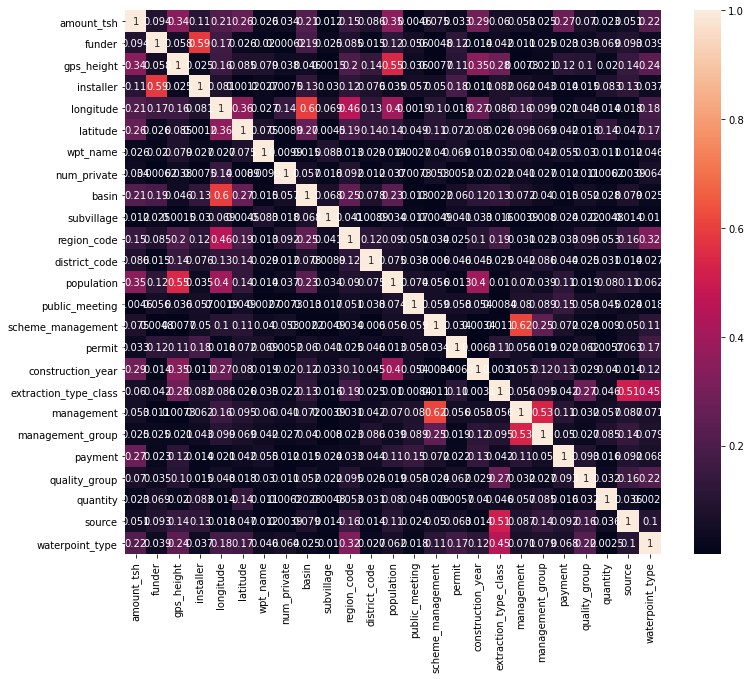

In [ ]:
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_train.columns = X.columns
X_test.columns = X.columns
print(X_train.mean())
print(X_train.std())

corrMatrix = X_train.corr(method='spearman')
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(abs(corrMatrix), annot = True)
plt.show()

As can be seen that the mean of all the columns is now close to 0 and the standard deviation for all the columns is close to 1 after the above cell. So, the data is now stadardised! The scaler fit on the train data is then applied on the validation data next.

In [ ]:
X_test = pd.DataFrame(scaler.transform(X_test))

print('Mean: ')
print(X_test.mean())
print('Standard Deviation: ')
print(X_test.std())

Mean: 
0     0.003633
1     0.011340
2    -0.000796
3    -0.005471
4    -0.006882
5     0.000583
6     0.008790
7    -0.016484
8     0.000757
9    -0.006038
10    0.000592
11   -0.000312
12    0.007028
13    0.016537
14    0.023412
15    0.012836
16   -0.002347
17   -0.025953
18    0.018467
19    0.025379
20    0.000902
21   -0.015341
22    0.021279
23    0.028277
24    0.003060
dtype: float64
Standard Deviation: 
0     0.803942
1     1.000146
2     0.997585
3     0.997324
4     1.009858
5     1.011926
6     0.997680
7     0.295378
8     0.982736
9     1.004123
10    1.007651
11    1.003367
12    0.948412
13    1.012908
14    0.977784
15    0.996677
16    0.998403
17    0.984155
18    0.985826
19    0.957180
20    0.999899
21    0.986541
22    0.994657
23    0.985860
24    1.001336
dtype: float64


So the means of all the columns of validation data are now close to 0 and the standard deviations are close to 1.

## Models

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import f1_score, make_scorer, roc_auc_score

def model_train_and_cv(model, params, cv, X_train, y_train):
  print('Tuning Hyperparameters using GridSearchCV...') 

  f1 = make_scorer(f1_score , average='macro')
  clf = GridSearchCV(model, param_grid=params, scoring=f1, cv=cv)  # Hyperparameter tuning
  clf.fit(X_train, y_train)
  
  print('Best parameters: ')
  print(clf.best_params_)
  print('Best score: ')
  print(clf.best_score_)

  return clf

def test_and_report_error(model_name, X_test, y_test):
  print('Test Classification report:')
  y_true, y_pred = np.squeeze(y_test), model_name.predict(np.array(X_test))
  print(classification_report(y_true, y_pred))

In [ ]:
# Random Forest 

from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
params = {'n_estimators':[30, 40, 50], 'random_state':[1, 42], 'criterion':['entropy', 'gini']} 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

rf = model_train_and_cv(clf_rf, params, cv, X_train, y_train)
test_and_report_error(rf, X_test, y_test)

Tuning Hyperparameters using GridSearchCV...


KeyboardInterrupt: ignored

In [ ]:
# Naive Bayes Classifier. Reference used: https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn

from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB()
params = {'var_smoothing': [1e-8, 1e-9, 1e-10]}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

nb = model_train_and_cv(clf_nb, params, cv, X_train, y_train)
test_and_report_error(nb, X_test, y_test)

Tuning Hyperparameters using GridSearchCV...
Best parameters: 
{'var_smoothing': 1e-08}
Best score: 
0.45233494572246274
Test Classification report:
              precision    recall  f1-score   support

           0       0.71      0.50      0.59      4810
           1       0.13      0.43      0.20       673
           2       0.61      0.58      0.59      3427

    accuracy                           0.53      8910
   macro avg       0.48      0.50      0.46      8910
weighted avg       0.63      0.53      0.56      8910



In [ ]:
# Tree Based Methods

from sklearn import tree

clf_tree = tree.DecisionTreeClassifier() # for classification, here you can change the algorithm as gini or entropy (information gain) by default it is gini  
params = {'criterion': ['gini', 'entropy']}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

tr = model_train_and_cv(clf_tree, params, cv, X_train, y_train)
test_and_report_error(tr, X_test, y_test)

Tuning Hyperparameters using GridSearchCV...
Best parameters: 
{'criterion': 'entropy'}
Best score: 
0.618711248728516
Test Classification report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      4872
           1       0.35      0.33      0.34       648
           2       0.75      0.75      0.75      3390

    accuracy                           0.74      8910
   macro avg       0.63      0.63      0.63      8910
weighted avg       0.74      0.74      0.74      8910



In [ ]:
# Bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

clf_bag = BaggingClassifier()
params = {'base_estimator':[SVC(), tree.DecisionTreeClassifier()], 'n_estimators':[5, 7, 10], 'random_state': [1, 42]}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

bag = model_train_and_cv(clf_bag, params, cv, X_train, y_train)
test_and_report_error(bag, X_test, y_test)

The bagging model with base estimator as SVC() didn't converge for a long time.

In [ ]:
# Boosting - AdaBoostClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

params = {"base_estimator__criterion" : ["gini", "entropy"], "base_estimator__splitter" :   ["best", "random"], "n_estimators": [50, 60]}
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced", max_depth = None)
clf_ada = AdaBoostClassifier(base_estimator = DTC)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

ada_boost = model_train_and_cv(clf_ada, params, cv, X_train, y_train)
test_and_report_error(ada_boost, X_test, y_test)

In [ ]:
## Gradient Boosting Classifier. Reference used: https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

params = {"learning_rate":[0.1, 0.25, 0.5, 1], "n_estimators": [20, 30], "random_state":[0,12]}
# DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced", max_depth = None)
clf_grad = GradientBoostingClassifier(max_features=2, max_depth=2)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

grad_boost = model_train_and_cv(clf_grad, params, cv, X_train, y_train)
test_and_report_error(grad_boost, X_test, y_test)

In [ ]:
# SVC: Support Vector Machine

from sklearn import svm

clf_svc = svm.SVC()
params = {'kernel':('rbf', 'linear', 'poly'), 'C':[0.1, 1, 10, 100], 'degree':[3,5,8]} # C: different regularization parameters
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

svc = model_train_and_cv(clf_svc, params, cv, X_train, y_train)
test_and_report_error(svc, X_test, y_test)

The Support Vector Machine Model didn't converge for a long time for this dataset.

In [ ]:
from sklearn.neural_network import MLPClassifier

clf_NN = MLPClassifier(solver='lbfgs', random_state=1, max_iter=2500, hidden_layer_sizes=(5,2))
params = {'alpha':[1e-5, 1e-2, 1, 10]}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

NN = model_train_and_cv(clf_NN, params, cv, X_train, y_train)
test_and_report_error(NN, X_test, y_test)

## Importance of different features

In [ ]:
def feature_imp(model_name):
  dset = pd.DataFrame()
  dset['attr'] = train_df_final.drop(['status_group'], axis=1).columns
  dset['importance'] = model_name.best_estimator_.feature_importances_
  
  dset = dset.sort_values(by='importance', ascending=False)

  plt.figure(figsize=(16, 14))
  plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
  plt.title('Feature Importances', fontsize=20, fontweight='bold', pad=20)
  plt.xlabel('Importance', fontsize=14, labelpad=20)
  plt.show()

In [ ]:
feature_imp(grad_boost)

## Visualisation of Decision Boundaries

In [ ]:
X_train.shape

(35640, 26)

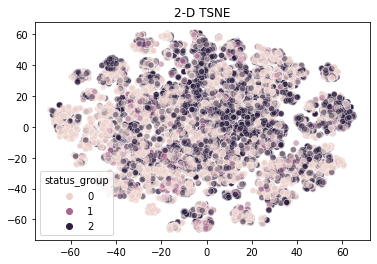

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
tsne_dims = tsne.fit_transform(np.array(X_train))

sns.scatterplot(x=tsne_dims[:,0], y=tsne_dims[:,1], alpha=.5, hue=y_train)
plt.title('2-D TSNE')
plt.show()

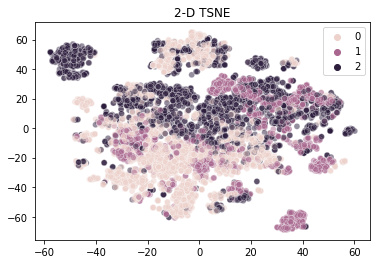

In [ ]:
tsne = TSNE(n_components=2, perplexity=100)
tsne_dims = tsne.fit_transform(np.array(X_test))
y_pred = nb.predict(X_test)
sns.scatterplot(x=tsne_dims[:,0], y=tsne_dims[:,1], alpha=.5, hue=y_pred)
plt.title('2-D TSNE')
plt.show()

## Predictions on the test data

In [ ]:
test_df.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,quality_group,quantity,source,waterpoint_type
0,0.0,Kuamu,1676,Kuamu,35.247289,-8.113243,none,0,Rufiji,Mahanzi,11,1,769,True,VWC,True,2004,gravity,vwc,user-group,never pay,good,dry,spring,communal standpipe
1,0.0,Kirde,0,DWE,36.163435,-5.218454,Zahanati,0,Wami / Ruvu,Uzunguni,1,1,0,True,VWC,False,0,motorpump,vwc,user-group,never pay,good,enough,machine dbh,communal standpipe
10,0.0,Hesawa,0,DWE,30.819530,-1.407397,Kwantimbo,0,Lake Victoria,Bwonyo,18,1,0,True,WUG,True,0,gravity,vwc,user-group,never pay,good,dry,spring,communal standpipe
11,0.0,Norad,1309,NORAD,30.026603,-4.774202,Kwa Rutebuka,0,Lake Tanganyika,Kasangezi,16,2,540,True,Water authority,True,1983,gravity,vwc,user-group,never pay,good,insufficient,spring,communal standpipe
17,0.0,District Council,1714,District council,37.578488,-3.157051,Kwa Mathias Rima,0,Pangani,Amrushu Mseta,3,1,1,True,Company,True,2010,gravity,company,commercial,never pay,good,enough,spring,communal standpipe


In [ ]:
test_df.dropna(axis=0, inplace=True)
test_df = test_df.drop(['Unnamed: 0','id','date_recorded','recorded_by','scheme_name', 'region', 'quantity_group', 'extraction_type', 'extraction_type_group', 'payment_type', 'water_quality', 'source_type', 'source_class', 'waterpoint_type_group', 'lga', 'ward'], axis=1)

In [ ]:
test_df[cat_data].shape

(6961, 16)

In [ ]:
for col in cat_data:
  test_df[col] = feature_enc.transform(test_df[col].astype('str'))

ValueError: ignored

# References Used:
https://www.analyticsvidhya.com/blog/2016/04/tree-based-algorithms-complete-tutorial-scratch-in-python/